# Imports

In [1]:
## !pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [4]:
train = pd.read_csv("diabetic_data_train.csv")
test = pd.read_csv("diabetic_data_test.csv")
print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (76324, 51)
Shape of test data: (25442, 51)


- The Train Dataset contains 76324 rows while the Test Dataset contains 25442 rows.

- Number of Feature columns: 50 
- Number of Target column = 1

In [5]:
print(f"Total Number of rows in Train and Test Data: {train.shape[0]+test.shape[0]}")

Total Number of rows in Train and Test Data: 101766


# Basic Data Information

**Concatenating Train and Test dataset for EDA, Data Cleaning and Feature Engineering.**

Concatenation is done to make sure that same Data Cleaning and Feature Engineering processes are applied to both Train and Test Dataset.

In [6]:
concat = pd.concat([train,test],axis=0)

**Checking Data Types of columns**

In [7]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 25441
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                101766 non-null  int64 
 1   encounter_id              101766 non-null  int64 
 2   patient_nbr               101766 non-null  int64 
 3   race                      101766 non-null  object
 4   gender                    101766 non-null  object
 5   age                       101766 non-null  object
 6   weight                    101766 non-null  object
 7   admission_type_id         101766 non-null  int64 
 8   discharge_disposition_id  101766 non-null  int64 
 9   admission_source_id       101766 non-null  int64 
 10  time_in_hospital          101766 non-null  int64 
 11  payer_code                101766 non-null  object
 12  medical_specialty         101766 non-null  object
 13  num_lab_procedures        101766 non-null  int64 
 14  num_p

**Dropping the 'Unnamed: 0' column**. 

Such column is formed when while saving the dataframe into CSV we perform `df.to_csv()` without passing `index=False` parameter. This column contains integers from zero to length of dataframe minus one

In [8]:
concat.drop("Unnamed: 0", axis=1, inplace=True)

**Checking the number of Numeric and Categorical Columns**

In [9]:
print("Number of numeric columns:", len(concat.select_dtypes(include=np.number).columns))
print("Number of categorical columns:", len(concat.select_dtypes(include=object).columns))

Number of numeric columns: 13
Number of categorical columns: 37


**Checking Null values in the columns**

In [10]:
concat.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

As per the Null value test performed above there are no Null values in the dataset. However as per the Data Description there are null values in the dataset. They are probably denoted by something other than "Nan" or "Null"

In [11]:
concat.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,338369606,159605546,AfricanAmerican,Male,[70-80),?,1,23,7,3,...,No,No,No,No,No,No,No,No,No,NO
1,90739116,83232054,Caucasian,Female,[70-80),[75-100),3,1,1,1,...,No,No,No,No,No,No,No,No,No,NO
2,64286964,95117913,Caucasian,Male,[60-70),?,3,1,1,4,...,No,No,No,No,No,No,No,Ch,Yes,>30
3,376610012,136697972,AfricanAmerican,Male,[40-50),?,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
4,110557278,2851308,Caucasian,Male,[80-90),?,1,1,6,1,...,No,No,No,No,No,No,No,No,No,NO


we can see null values are represented as '?'

We have to take care of these values before modelling

**Converting target column from multivariate to Bivariate**

Currently the Target Column "readmitted" containes three classes:
- `No`
- `>30`
- `<30`

The objective of this predictive analysis is to build a binary classification model that can predict early (`<30` days) readmission given the patient’s features.

So we will be grouping category `No` and category `>30` together and make them as one category whereas `<30` will be one seperate category

In [12]:
concat["readmitted"].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [13]:
# values that are not '<30' will be converted to others
def binary(c):
    if c == "<30":
        return "<30"
    else:
        return "Other"
        
concat["readmitted"] = concat["readmitted"].apply(binary)

In [14]:
concat["readmitted"].value_counts()

Other    90409
<30      11357
Name: readmitted, dtype: int64

One thing we can note here is that the dataset is immalanced with respect to the Target column.

# EDA

**Univariate Analysis**

In [15]:
# Selecting Categorical and Numerical columns for EDA
num = concat.select_dtypes(include=np.number).columns
cat = concat.select_dtypes(object).columns

Plotting distplot for numerical columns and also measuring skewness and kurtosis

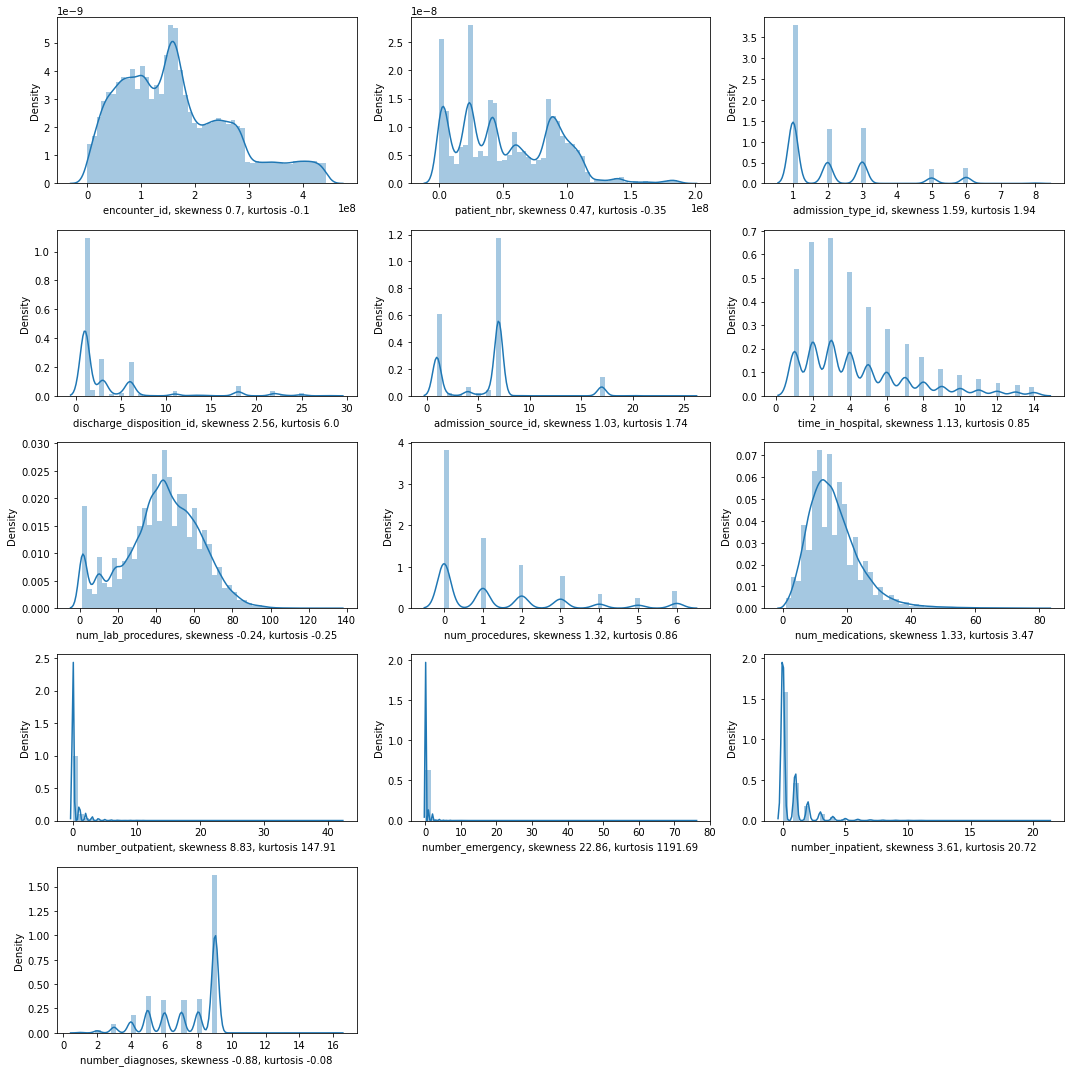

In [16]:
plt.figure(figsize=(15,15))
c=1
for col in num:
    try:
        plt.subplot(5,3,c)
        sns.distplot(concat[col])
        plt.xlabel(f"{col}, skewness {np.round(concat[col].skew(),2)}, kurtosis {np.round(concat[col].kurtosis(),2)}")
        c+=1
    except:
        continue
plt.tight_layout()

**Insights from the above plots**
- num_lab procedures distribution is fairly symmetrical
- admission_source_id, number_diagnosis columns are moderaltely skewed
- rest distribution are highly skewed

**Plotting for categorical columns**

Plotting for only those columns where the number of unique categories is less than 11 so that bars on plot are easier to visualize. And also not plotting for those categorical columns where there is only one category as that plot doesnt provide any information

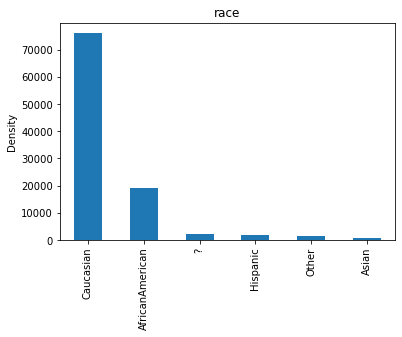

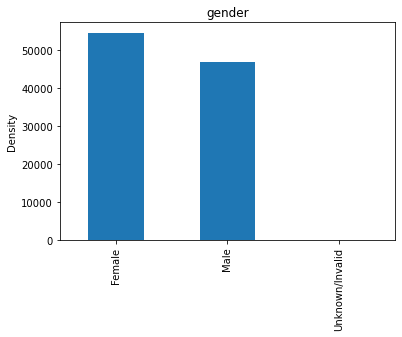

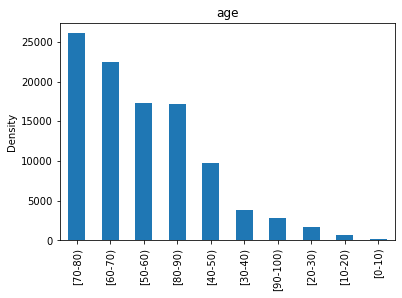

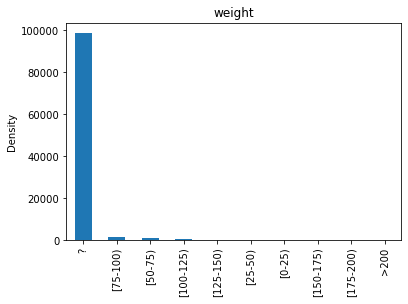

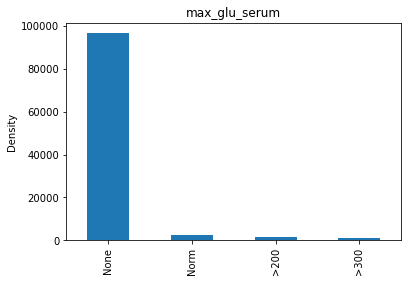

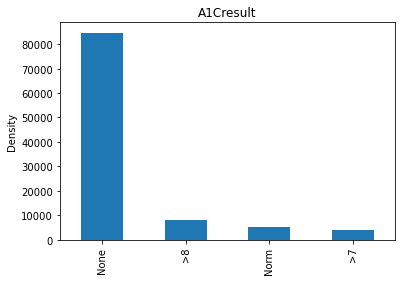

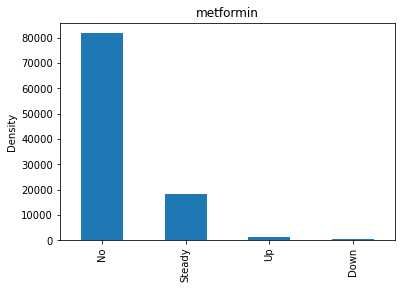

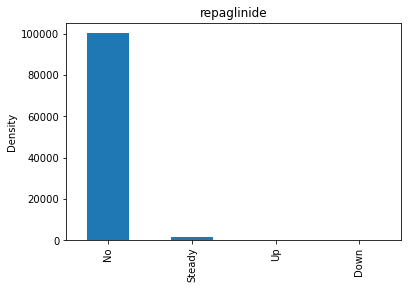

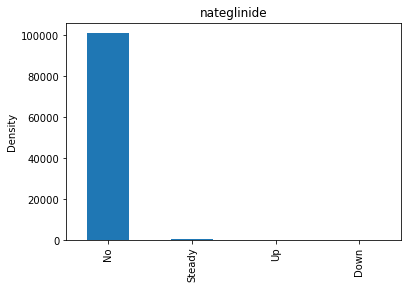

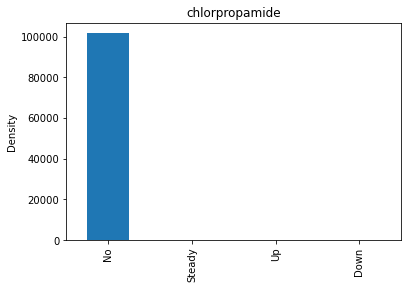

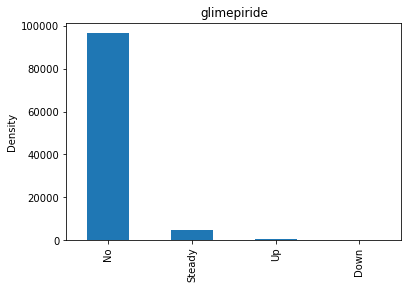

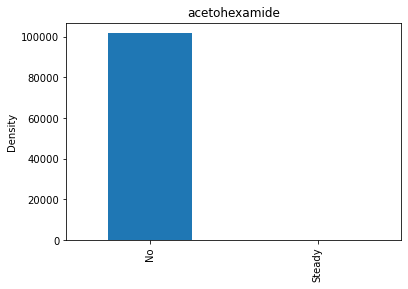

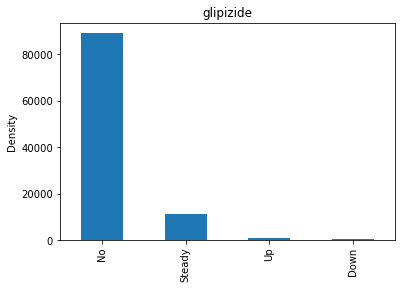

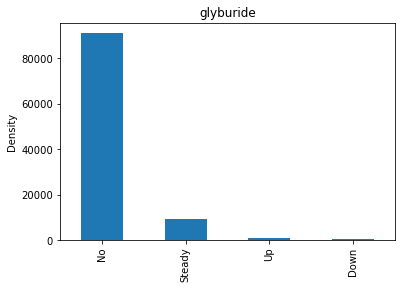

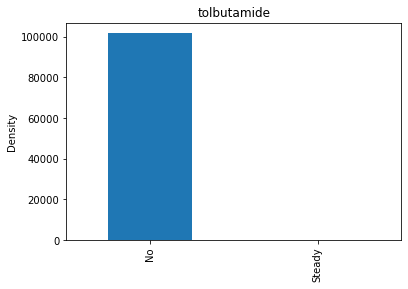

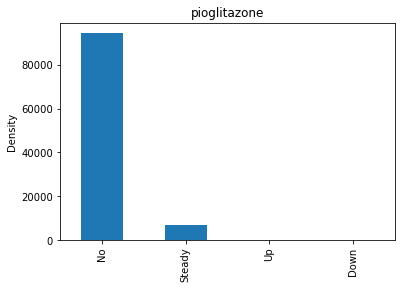

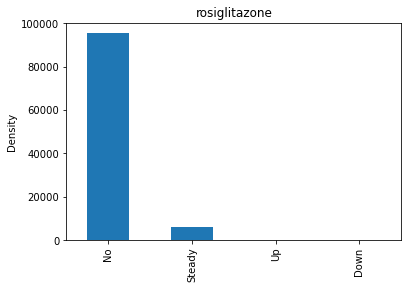

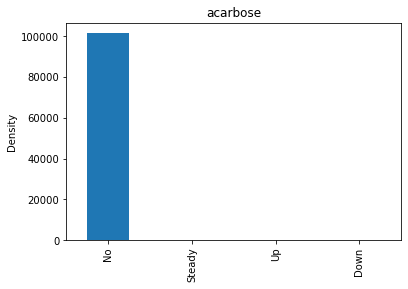

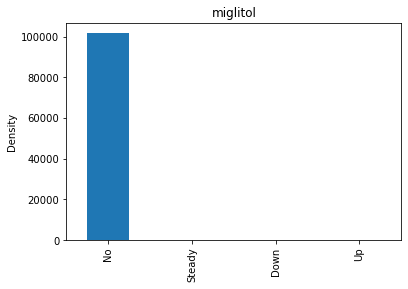

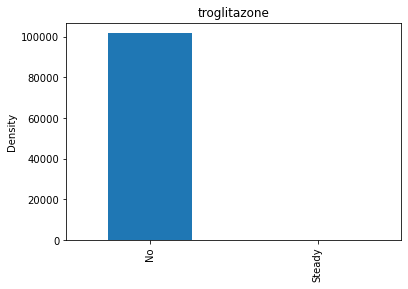

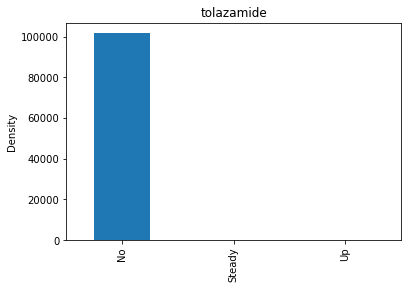

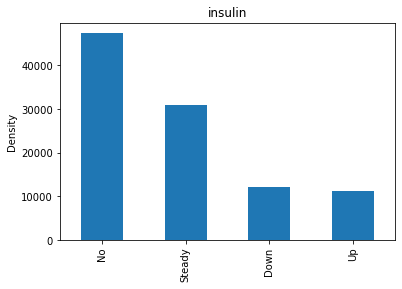

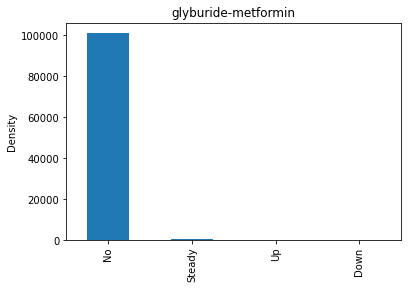

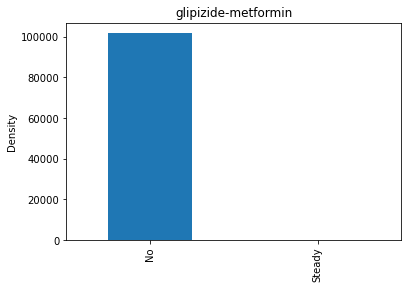

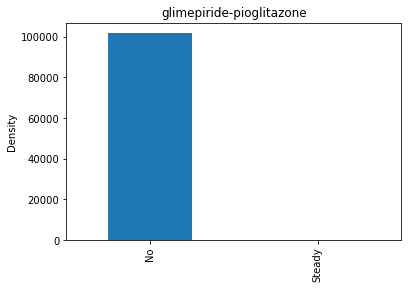

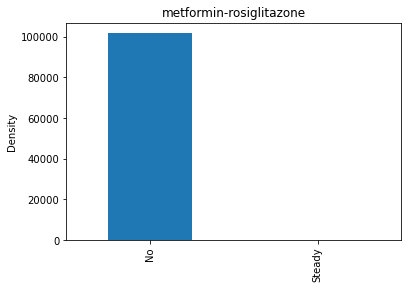

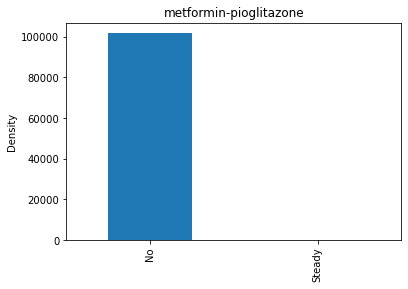

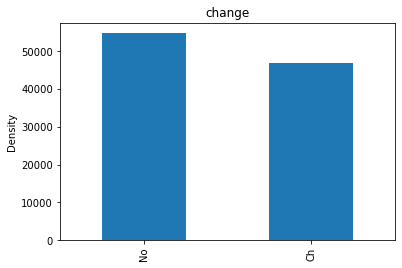

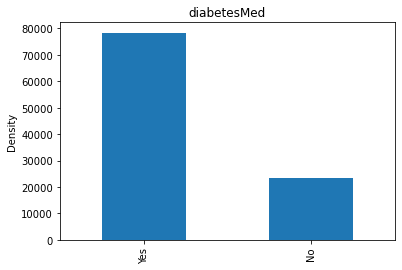

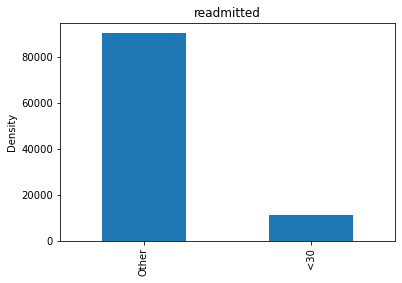

In [17]:
for col in cat:
    valueCounts = concat[col].value_counts()
    if 1 < len(valueCounts) <= 10:
        valueCounts.plot(kind="bar")
        plt.title(col)
        plt.ylabel("Density")
        plt.show()

**Insights from above Plots**
- `Race` columns has 5 races and also some null values represented by ?, The data has most entries of people who are originated from caucasian or are African American
- Number of Females and Males are almost same but data contains slightly more entries of Females
- `Age` 50-70 as expected has more enteries as they have more chances to get admitted in a hospital
- 97% values in `weight` are missing so it will be good to drop this column
- 52% values are missing in `payer code` and 53% values are missing in medical_speciality. Dropping or filling null value will completely depend on chi square test. If this column is found significant then we will use some method of imputation to fill null values and then will do binning to reduce category otherwise will drop it.
- `diag1`, `diag2` and `diag3` must be binned before building model.
- majorly glucose and A1C test are not measured in a patient
- Their are many columns representing genetic medication which have only single value so they will be dropped as they contain no information
- Target column is highly immbalanced

**Bivariate Analysis**

In [18]:
#removing target column from categical column name list
cat = cat[:-1]

**Ploting Correlation Heatmap**

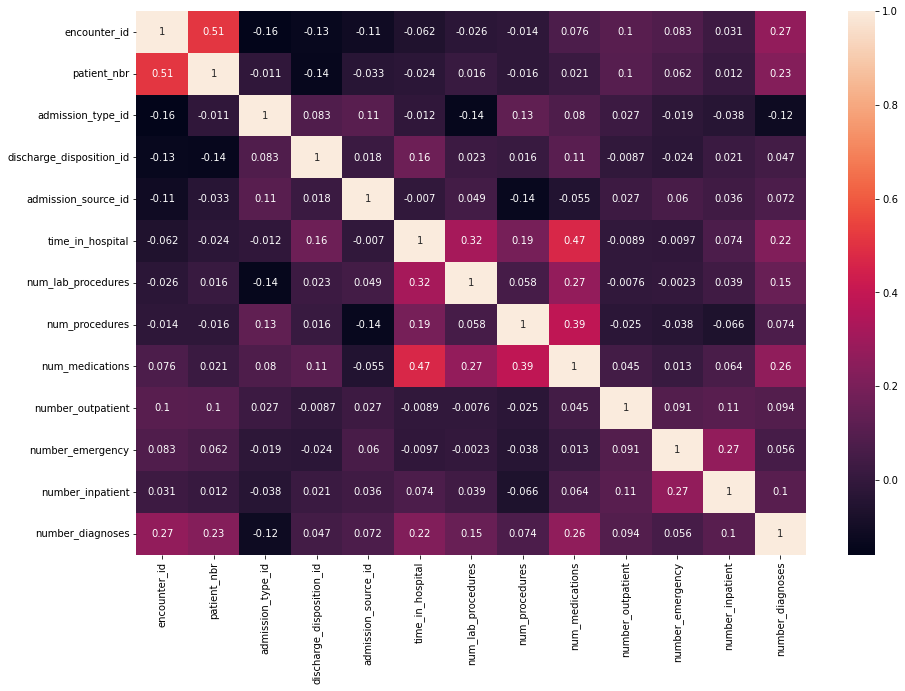

In [19]:
plt.figure(figsize=(15,10))
sns.heatmap(concat.corr(), annot=True)
plt.show()

**Insights from above heamap:**

- `encounter_id` and `patient_nbr` have high positive correlation
- `time_in_hospital` and `num_medication` also have high positive correlation
- `time_in_hospital`, `num_lab_procedures`, `num_procedures` and `num_medication` also have good positive correlation 

**Bivariate analysis between numeric variable and target columns(categorical)**

This tell us whats the median for numeric column to be readmitted in <30 days

In [20]:
for col in num:
    print(f'Median value of readmission in {col}')
    print(concat.groupby("readmitted")[col].median(), "\n")

Median value of readmission in encounter_id
readmitted
<30      149771196.0
Other    152700834.0
Name: encounter_id, dtype: float64 

Median value of readmission in patient_nbr
readmitted
<30      48139200.0
Other    45321912.0
Name: patient_nbr, dtype: float64 

Median value of readmission in admission_type_id
readmitted
<30      1.0
Other    1.0
Name: admission_type_id, dtype: float64 

Median value of readmission in discharge_disposition_id
readmitted
<30      2.0
Other    1.0
Name: discharge_disposition_id, dtype: float64 

Median value of readmission in admission_source_id
readmitted
<30      7.0
Other    7.0
Name: admission_source_id, dtype: float64 

Median value of readmission in time_in_hospital
readmitted
<30      4.0
Other    4.0
Name: time_in_hospital, dtype: float64 

Median value of readmission in num_lab_procedures
readmitted
<30      45.0
Other    44.0
Name: num_lab_procedures, dtype: float64 

Median value of readmission in num_procedures
readmitted
<30      1.0
Other 

**Bivariate analysis between categorical columns and target column (category)**

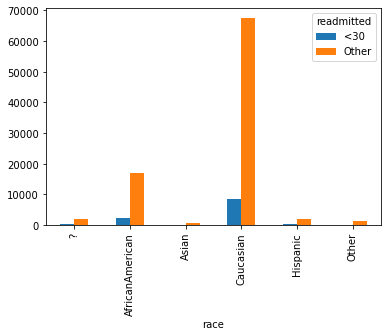

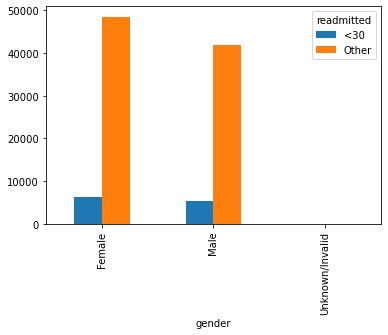

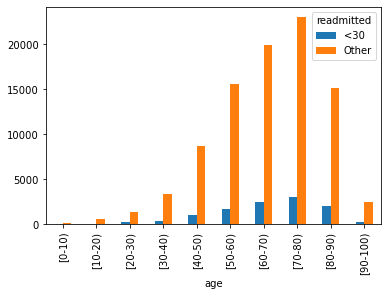

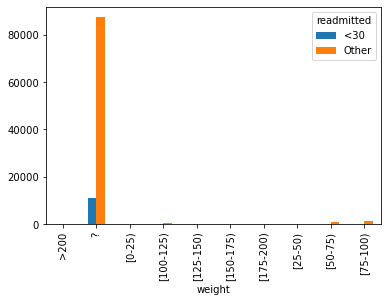

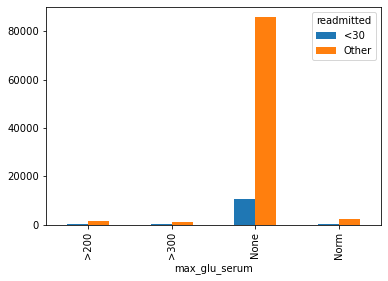

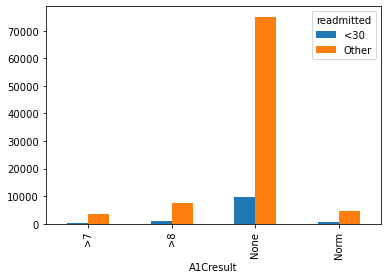

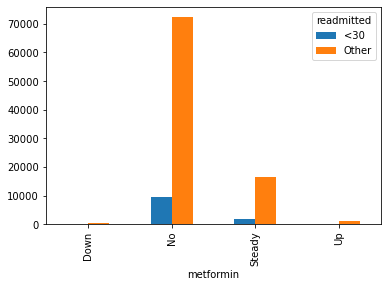

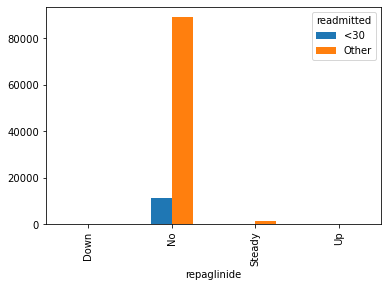

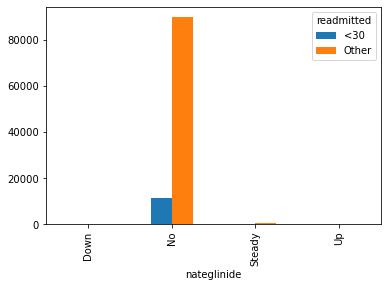

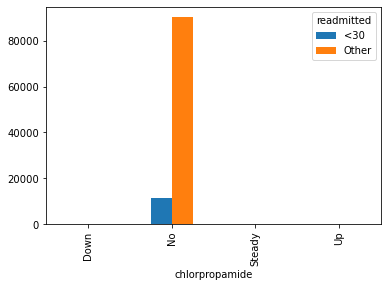

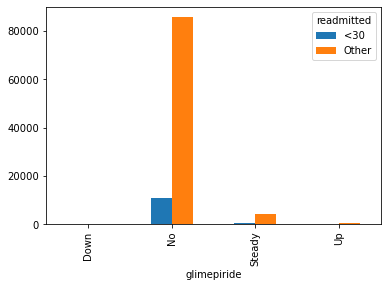

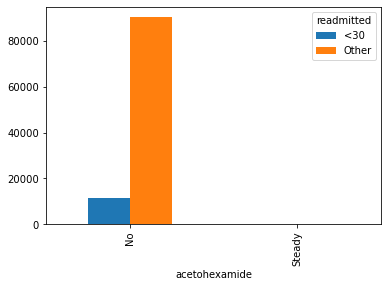

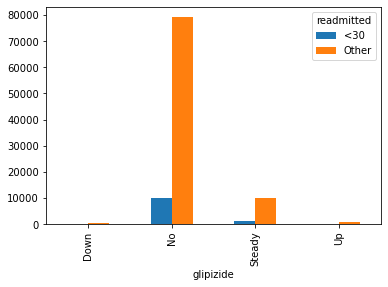

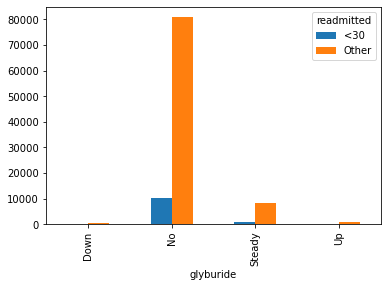

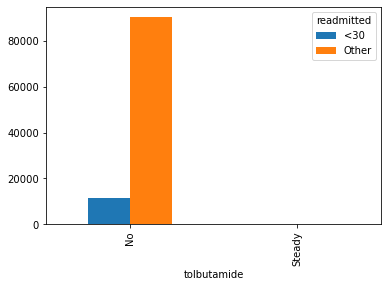

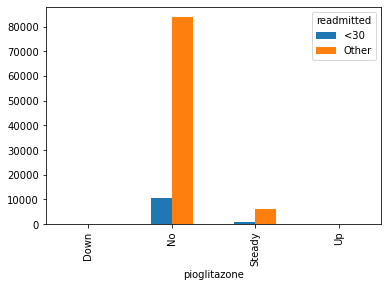

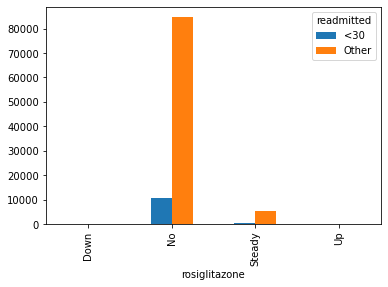

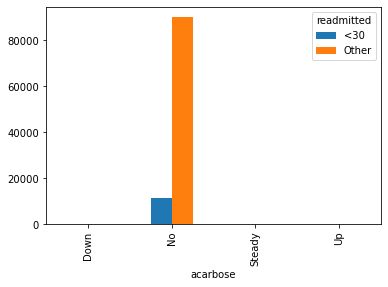

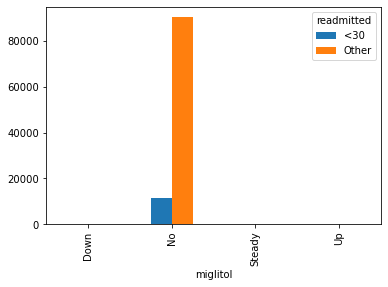

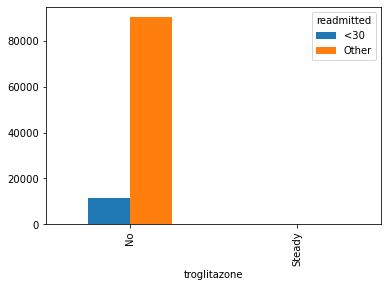

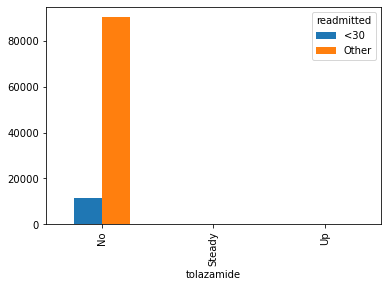

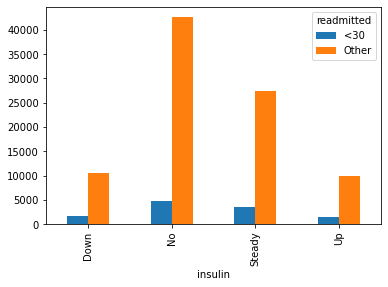

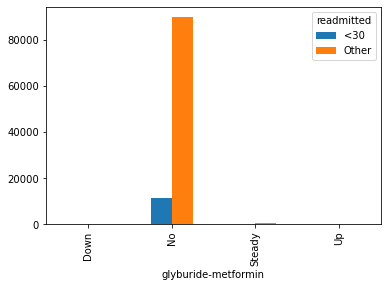

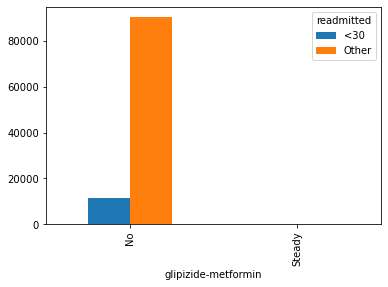

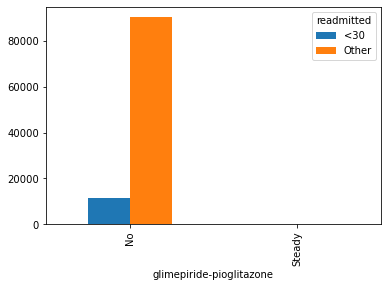

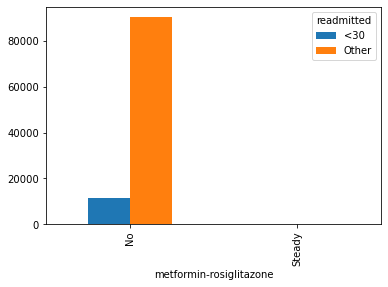

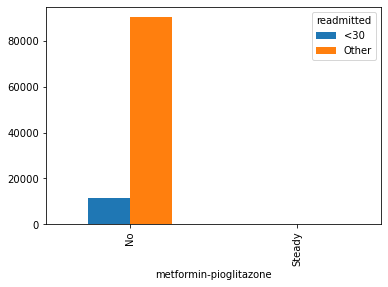

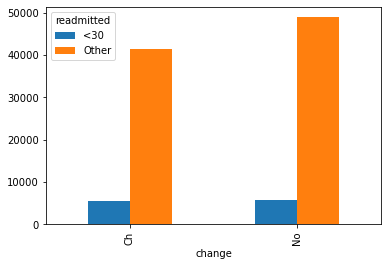

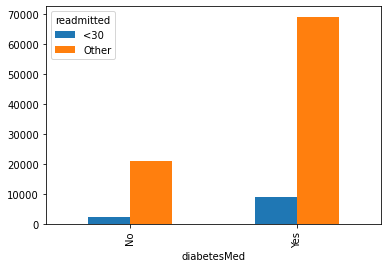

In [21]:
for col in cat:
    valueCounts = concat[col].value_counts()
    if 1 < len(valueCounts) <= 10:
        pd.crosstab(concat[col], concat["readmitted"]).plot(kind="bar")
        plt.show()
        print("\n")

**Insights from above plots:**

- `Race` which belongs to Caucasian and African American have more chances of readmitted within 30 days
- `Age` 50-90 have more chances of readmitting within 30 days
- `Payer code` with missing value, MC and HM have more chances of readmitting within 30 days
- All patient with diabatic and genetic medication not prescribed have more chances to get readmmited within 30 days

# Data Cleaning and Feature Engineering

`Weight` column has 97% missing values so dropping that column

In [22]:
# Dropping inplace
concat.drop("weight", axis=1, inplace=True)

Imputing Null (?) `race` column values with mode

In [23]:
concat.loc[concat["race"] == "?", "race"] = concat["race"].mode().values[0]

Applying statistical test on `payer code` to check if they are significant or not

In [24]:
#Not taking ? as its representation of null value and will effect our statistical test
table = pd.crosstab(concat["payer_code"], concat["readmitted"]).iloc[1:]
print(chi2_contingency(table))
#Pval = 1.1320694704249227e-12, i.e<0.05 hence rejecting null hypothesis 

(91.86620508941405, 1.1320694704249227e-12, 16, array([[5.09317997e+02, 4.14568200e+03],
       [1.59743131e+01, 1.30025687e+02],
       [2.11933182e+02, 1.72506682e+03],
       [2.77143391e+02, 2.25585661e+03],
       [6.00677939e+01, 4.88932206e+02],
       [1.09413104e-01, 8.90586896e-01],
       [6.86457812e+02, 5.58754219e+03],
       [3.54925167e+03, 2.88897483e+04],
       [3.86447082e+02, 3.14555292e+03],
       [8.64363518e+00, 7.03563648e+01],
       [1.13023736e+02, 9.19976264e+02],
       [1.03942448e+01, 8.46057552e+01],
       [6.47725573e+01, 5.27227443e+02],
       [6.01772070e+00, 4.89822793e+01],
       [5.47831410e+02, 4.45916859e+03],
       [2.67843278e+02, 2.18015672e+03],
       [1.47707690e+01, 1.20229231e+02]]))


In [25]:
# filling null values with mode
# Note: missing values in the dataset is reprsented by ?
concat.loc[concat["payer_code"] == "?", "payer_code"] = concat["payer_code"].value_counts().index[1]

Applying statistical test on `medical speciality` to check if they are significant or not

In [26]:
#Not taking ? as its representation of null value and will effect our statistical test
table = pd.crosstab(concat["medical_specialty"], concat["readmitted"]).iloc[1:]
print(chi2_contingency(table))
#Pval = 1.2613320083518932e-36 , i.e<0.05 hence rejecting null hypothesis 

(339.2884913048497, 1.2613320083518932e-36, 71, array([[7.53266303e-01, 6.24673370e+00],
       [1.29131366e+00, 1.07086863e+01],
       [2.04457996e+00, 1.69554200e+01],
       [5.75925893e+02, 4.77607411e+03],
       [7.53266303e-01, 6.24673370e+00],
       [6.45656831e-01, 5.35434317e+00],
       [4.30437887e-01, 3.56956211e+00],
       [1.07609472e-01, 8.92390528e-01],
       [8.14065654e+02, 6.75093435e+03],
       [1.29131366e+01, 1.07086863e+02],
       [8.60875774e-01, 7.13912423e+00],
       [8.00614470e+02, 6.63938553e+03],
       [6.06917421e+01, 5.03308258e+02],
       [6.24134936e+00, 5.17586506e+01],
       [8.82397669e+00, 7.31760233e+01],
       [2.22751607e+01, 1.84724839e+02],
       [6.13373989e+00, 5.08662601e+01],
       [3.98155046e+00, 3.30184495e+01],
       [1.57486462e+03, 1.30601354e+04],
       [1.73574078e+02, 1.43942592e+03],
       [2.18447228e+01, 1.81155277e+02],
       [1.07609472e-01, 8.92390528e-01],
       [2.69023679e+00, 2.23097632e+01],
       [2

In [27]:
# Filling null values with mode
concat.loc[concat["medical_specialty"] == "?", "medical_specialty"] = concat["medical_specialty"].value_counts().index[1]

Filling missing values of `diag3` with mode

In [28]:
concat.loc[concat["diag_3"] == "?", "diag_3"] = concat["diag_3"].mode().values[0]

Dropping columns which have only 1 cateogory in it

In [29]:
cols = []
cat = concat.select_dtypes(include=object)
for col in cat:
    if len(concat[col].value_counts().index)==1:
        cols.append(col)

print("Columns to drop: ", cols)

concat.drop(cols, axis=1, inplace=True)

Columns to drop:  ['examide', 'citoglipton']


Dropping columns based on low variance

In [30]:
var = concat.agg("var", numeric_only=True)
concat = concat.drop(columns=var[var.between(0, 0.0001)].index)

Binning Diag1, Diag2 , Diag3 as given in ICD-9 code

https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [31]:
def diag(v):
    try:
        v = int(v)
        if v<140:
            return "infectious and parasitic diseases"
        elif v>139 and v<240:
            return "neoplasms"
        elif v>239 and v<280:
            return "endocrine, nutritional and metabolic diseases, and immunity disorders"
        elif v>279 and v<290:
            return "diseases of the blood and blood-forming organs"
        elif v>289 and v <320:
            return "mental disorders"
        elif v>=320 and v<=389:
            return "diseases of the nervous system and sense organs"
        elif v>=390 and v<=459:
            return "diseases of the circulatory system"
        elif v>=460 and v<=519:
            return "diseases of the respiratory system"
        elif v>=520 and v<=579:
            return "diseases of the digestive system"
        elif v>=580 and v<=629:
            return "diseases of the genitourinary system"
        elif v>=630 and v<=679:
            return "complications of pregnancy, childbirth, and the puerperium"
        elif v>=680 and v<=709:
            return "diseases of the skin and subcutaneous tissue"
        elif v>=710 and v<=739:
            return "diseases of the musculoskeletal system and connective tissue"
        elif v>=710 and v<=739:
            return "diseases of the musculoskeletal system and connective tissue"
        elif v>=740 and v<=759:
            return  "congenital anomalies"
        elif v>=760 and v<=779:
            return "certain conditions originating in the perinatal period"
        elif v>=780 and v<=799:
            return "symptoms, signs, and ill-defined conditions"
        else:
            return  "injury and poisoning"
    except:
        return "external causes of injury and supplemental classification"

In [32]:
concat["diag_1"] = concat["diag_1"].apply(diag)
concat["diag_2"] = concat["diag_2"].apply(diag)
concat["diag_3"] = concat["diag_3"].apply(diag)

Unique categories and their frequency counts of Categorical Columns

In [33]:
for col in concat.select_dtypes(include=object):
    print(concat[col].value_counts())
    print("\n\n")

Caucasian          78372
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64



Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64



[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64



MC    72695
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64



InternalMedicine                    64584
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
Surgery-General                      3099
                                    ...  
SportsMedicine                          1
Per

**Binning `age` into `young`, `middle-age` and `old`**

In [34]:
def age(a):
    try:
        if int(a[4:6])<=20:
            return "Young"
        elif int(a[4:6])<20 and int(a[4:6])<=50:
            return "Middle Aged"
        elif int(a[4:6])>50:
            return "Old"
    except:
        return "Young"
concat["age"]=(concat["age"].apply(age))
    

Dropping `medical_speciality` as its contain lots of categories in it

In [35]:
concat.drop("medical_specialty", axis=1,inplace=True)

dropping `encounter_id` and `patient_nbr`

In [36]:
concat.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

**Encoding Categorical columns**

In [37]:
#removing target column from dataframe
x = concat.drop("readmitted", axis=1)
y = concat["readmitted"]
# dopping first dummy for every categoey to remove multicolliniarity
x = pd.get_dummies(x, drop_first=True)

# Scaling and Dimensionality Reduction

**Scaling the data**

Standardize features by removing the mean and scaling to unit variance.

In [38]:
sc = StandardScaler()
sc.fit(x)
x_trans = sc.transform(x)

In [39]:
print(f"Shape of Data: {x_trans.shape}")

Shape of Data: (101766, 138)


**Dimensionality Reduction**

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.

In [40]:
outDim = 10
pca = PCA(n_components=outDim)
pca.fit(x_trans)

xReduced = pca.transform(x)
print(xReduced.shape)

(101766, 10)


# Model Training

## Preprocessing before Model training

**Encoding target column**

In [41]:
# Making <30 as poitive class so that we can get proper insieght how our model is doing on immbalanced class
y_ = y.copy()
y_ = y_.replace({"Other":0, "<30":1})

**Getting back our data in train and test set**

In [42]:
train_x = xReduced[0:76324]
train_y = y_.iloc[0:76324]
test_x = xReduced[76324:]
test_y = y_.iloc[76324:]

In [43]:
print(f"Shape of Train X: {train_x.shape}")
print(f"Shape of Train Y: {train_y.shape}")
print(f"Shape of Test X: {test_x.shape}")
print(f"Shape of Test T: {test_y.shape}")

Shape of Train X: (76324, 10)
Shape of Train Y: (76324,)
Shape of Test X: (25442, 10)
Shape of Test T: (25442,)


## Logistic Regression

In [44]:
# Initialize the classifier
lr = LogisticRegression()

# Fit the classifier on Train Data
lr.fit(train_x, train_y)

# Predict using the trained classsifier on Test Data
pred_y_log = lr.predict(test_x)

Analysing our prediction

In [45]:
valueCounts = pd.Series(pred_y_log).value_counts()
print(f"Number of people re-admitted within 30 days: {valueCounts[1]}")

Number of people re-admitted within 30 days: 2


Accuracy of Logistic Regression Model: 88.83% 

Confusion Matrix:



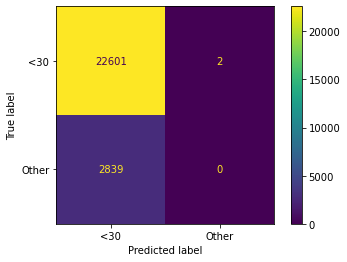

In [46]:
print(f"Accuracy of Logistic Regression Model: {round(accuracy_score(test_y, pred_y_log) * 100, 2)}% \n")
print("Confusion Matrix:\n")
conf_mat = confusion_matrix(test_y, pred_y_log)
classes = np.unique(y)

ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();

## Random Forest

In [47]:
# Initialize the classifier
rf = RandomForestClassifier()

# Fit the classifier on Train Data
rf.fit(train_x, train_y)

# Predict using the trained classsifier on Test Data
y_pred_rf = rf.predict(test_x)

Accuracy of Random Forest Model: 88.84%
Confusion Matrix:



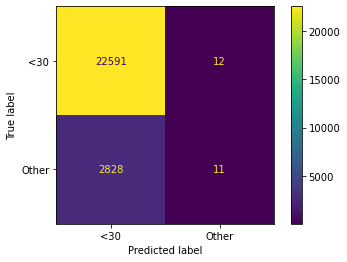

In [48]:
print(f"Accuracy of Random Forest Model: {round(accuracy_score(test_y, y_pred_rf) * 100, 2)}%")
print("Confusion Matrix:\n")
conf_mat = confusion_matrix(test_y, y_pred_rf)
classes = np.unique(y)

ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();

## Decision Tree Classifier

In [49]:
# Initialize the classifier
decModel = DecisionTreeClassifier(max_depth=5)

# Fit the classifier on Train Data
decModel.fit(train_x, train_y)

# Predict using the trained classsifier on Test Data
y_pred_dec = decModel.predict(test_x)

Accuracy of Decision Tree Model: 88.85%
Confusion Matrix:



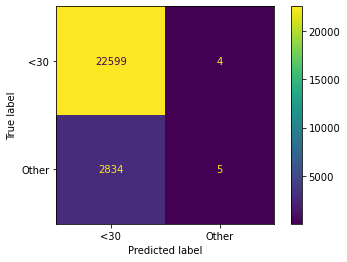

In [50]:
print(f"Accuracy of Decision Tree Model: {round(accuracy_score(test_y, y_pred_dec) * 100, 2)}%")
print("Confusion Matrix:\n")
conf_mat = confusion_matrix(test_y, y_pred_dec)
classes = np.unique(y)

ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();

## AdaBoost Classifier

In [51]:
# Initialize the classifier
adaBoostModel = AdaBoostClassifier()

# Fit the classifier on Train Data
adaBoostModel.fit(train_x, train_y)

# Predict using the trained classsifier on Test Data
y_pred_ada = adaBoostModel.predict(test_x)

Accuracy of Adaboost Model: 88.84%
Confusion Matrix:



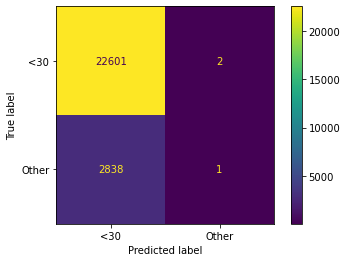

In [52]:
print(f"Accuracy of Adaboost Model: {round(accuracy_score(test_y, y_pred_ada) * 100, 2)}%")
print("Confusion Matrix:\n")
conf_mat = confusion_matrix(test_y, y_pred_ada)
classes = np.unique(y)

ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();

## XGBoost

In [53]:
# Initialize the classifier
xgbModel = xgb.XGBClassifier()

# Fit the classifier on Train Data
xgbModel.fit(train_x, train_y)

# Predict using the trained classsifier on Test Data
y_pred_xg = xgbModel.predict(test_x)

Accuracy of XGBoost Model: 88.81%
Confusion Matrix:



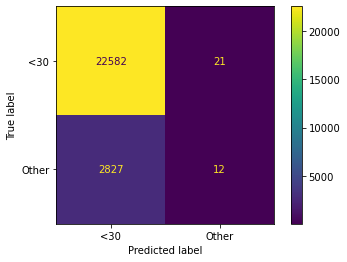

In [54]:
print(f"Accuracy of XGBoost Model: {round(accuracy_score(test_y, y_pred_xg) * 100, 2)}%")
print("Confusion Matrix:\n")
conf_mat = confusion_matrix(test_y, y_pred_xg)
classes = np.unique(y)

conf_df = pd.DataFrame(conf_mat, columns=classes, index=classes) 
ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();

# HyperParameter Tuning over Random Forest

Parameters used by Random Forest in default setting

In [55]:
# Initialize the classifier
rf = RandomForestClassifier()

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Create a parameter grid to sample from during fitting

In [56]:
# Number of trees in random forest
n_estimators = [100, 150, 200]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Use the random grid and RandomizedSeachCV to search for best hyperparameters

In [57]:
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using N fold cross validation
N = 3
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=5, cv=N, verbose=2, random_state=47, n_jobs=-1)

# Fit the random search model
rf_random.fit(train_x, train_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200]},
                   random_state=47, verbose=2)

Predicting with the best model

Accuracy of Random Forest Model: 88.85%
Confusion Matrix:



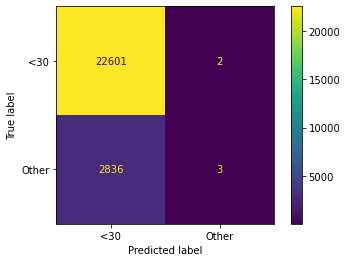

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  38.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  25.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  24.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  25.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  27.2s


In [58]:
y_pred_rf_nrm = rf_random.predict(test_x)
print(f"Accuracy of Random Forest Model: {round(accuracy_score(test_y, y_pred_rf_nrm) * 100, 2)}%")
print("Confusion Matrix:\n")
conf_mat = confusion_matrix(test_y, y_pred_rf_nrm)
classes = np.unique(y)

ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();